In [1]:
!pip install --quiet google-api-python-client textblob pandas seaborn matplotlib

In [2]:
from googleapiclient.discovery import build
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Getting comments

In [3]:
API_KEY = "YOUR API KEY"
VIDEO_ID = "8tiQuiCdbkM"

In [4]:
youtube = build('youtube', 'v3', developerKey=API_KEY)

In [12]:
def get_comments(video_id, max_comments=5000):
    comments = []
    next_page_token = None

    while len(comments) < max_comments:
        response = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=100,
            pageToken=next_page_token,
            textFormat="plainText"
        ).execute()

        for item in response["items"]:
            comment = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
            comments.append(comment)

        if "nextPageToken" not in response:
            break
        next_page_token = response["nextPageToken"]

    return comments[:max_comments]

In [13]:
comments = get_comments(VIDEO_ID)
df = pd.DataFrame(comments, columns=["comment"])

In [14]:
def analyze_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

df["sentiment"] = df["comment"].apply(analyze_sentiment)

/tmp/ipython-input-15-1156356724.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sentiment", palette="pastel")


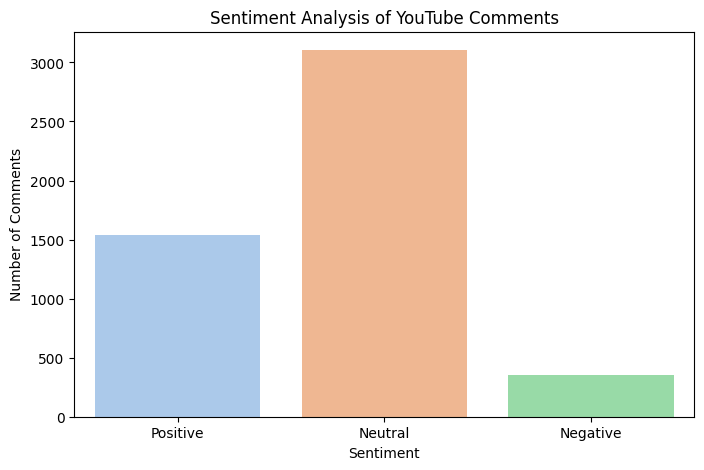

In [15]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="sentiment", palette="pastel")
plt.title("Sentiment Analysis of YouTube Comments")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.show()

In [16]:
df.head(10)

,comment,sentiment
0,Watch my latest Vlog on new channel also: http...,Positive
1,Plz government school ke develope karne ke liy...,Neutral
2,Itss been 5 years since the nep was announced ...,Neutral
3,Faltu step,Neutral
4,This is a good discussion of government.,Positive
5,Thank you for the detailed analysis.👍,Positive
6,NEP-National Education Policy,Neutral
7,2025 still nothing is implemented,Neutral
8,Government ab to government schools hi band k...,Neutral
9,That decision of NEP 2020 that one can take di...,Neutral


In [17]:
df.to_csv("youtube_sentiment_results.csv", index=False)

In [18]:
from google.colab import files
files.download("youtube_sentiment_results.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

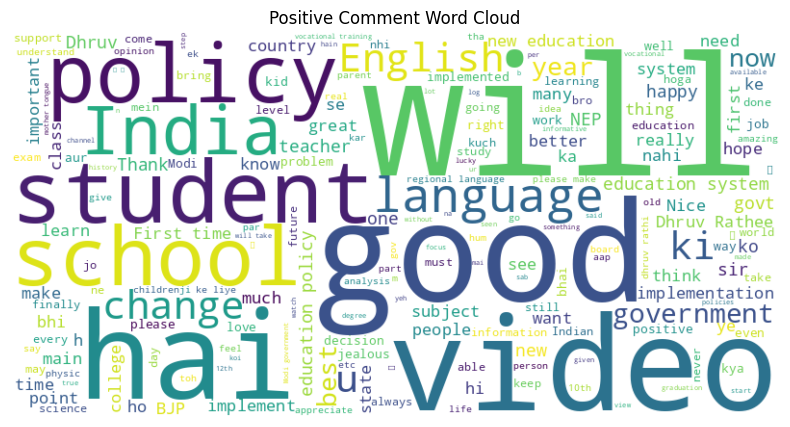

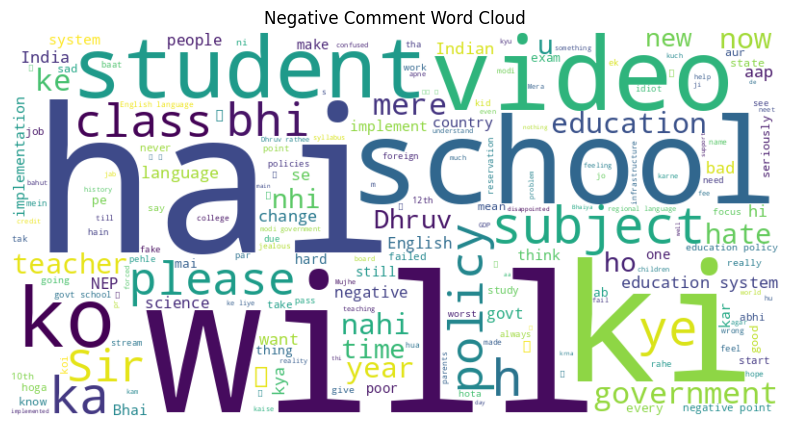

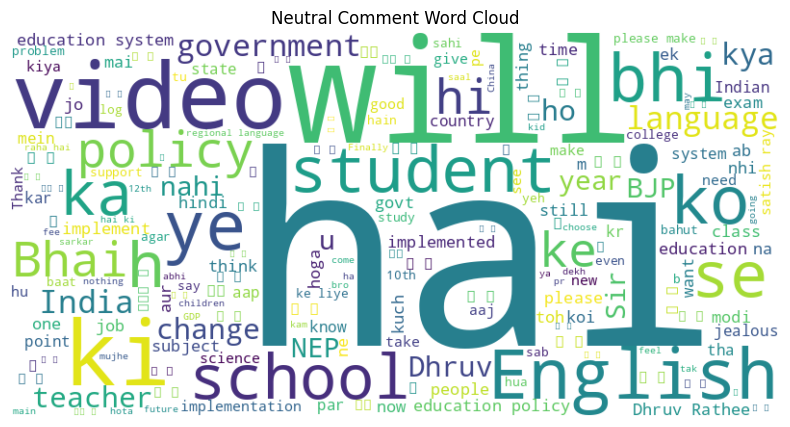

In [19]:
from wordcloud import WordCloud

for sentiment in ['Positive', 'Negative', 'Neutral']:
    text = " ".join(df[df['sentiment'] == sentiment]['comment'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{sentiment} Comment Word Cloud")
    plt.show()


# Multilingual Model

In [21]:
from transformers import pipeline
from tqdm import tqdm

In [22]:
classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


In [23]:
def get_sentiment(text):
    result = classifier(text[:512])[0]['label']
    if result == 'LABEL_0':
        return 'Negative'
    elif result == 'LABEL_1':
        return 'Neutral'
    else:
        return 'Positive'

In [24]:
tqdm.pandas()
df["sentiment"] = df["comment"].progress_apply(get_sentiment)

100%|██████████| 5000/5000 [13:19<00:00,  6.25it/s]


In [25]:
df.head(10)

,comment,sentiment
0,Watch my latest Vlog on new channel also: http...,Positive
1,Plz government school ke develope karne ke liy...,Positive
2,Itss been 5 years since the nep was announced ...,Positive
3,Faltu step,Positive
4,This is a good discussion of government.,Positive
5,Thank you for the detailed analysis.👍,Positive
6,NEP-National Education Policy,Positive
7,2025 still nothing is implemented,Positive
8,Government ab to government schools hi band k...,Positive
9,That decision of NEP 2020 that one can take di...,Positive


In [26]:
sns.set(style="whitegrid")

/tmp/ipython-input-27-2402194681.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sentiment", palette="pastel", order=["Positive", "Neutral", "Negative"])


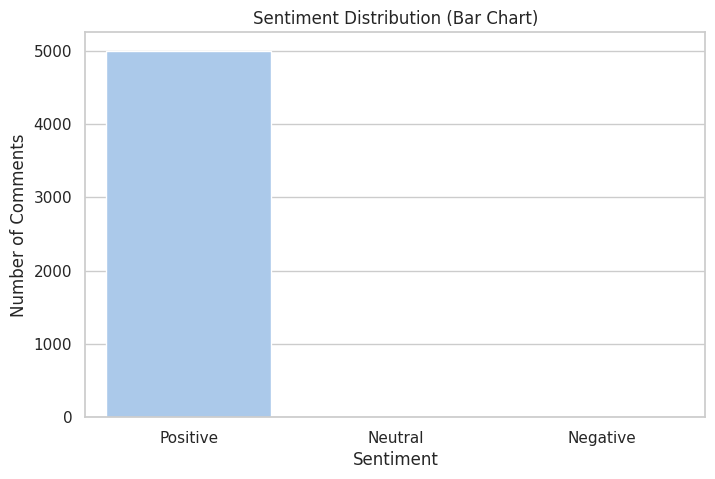

In [27]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="sentiment", palette="pastel", order=["Positive", "Neutral", "Negative"])
plt.title("Sentiment Distribution (Bar Chart)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.show()

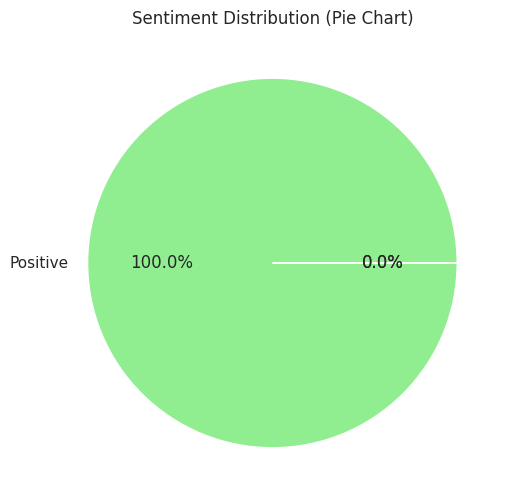

In [28]:
plt.figure(figsize=(6, 6))
df['sentiment'].value_counts().reindex(["Positive", "Neutral", "Negative"]).plot.pie(
    autopct='%1.1f%%', colors=['#90ee90', '#d3d3d3', '#ffcccb'], title="Sentiment Distribution (Pie Chart)")
plt.ylabel("")
plt.show()

In [29]:
df.to_csv("youtube_sentiment_xlmroberta.csv", index=False)

from google.colab import files
files.download("youtube_sentiment_xlmroberta.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>